In [7]:
import sys
paths_to_add = ["/homes/vk223/ProjectFlood", "/home/vkhandekar/project_flood"]
for p in paths_to_add:
    if p not in sys.path:
        sys.path.append(p)
print(sys.path)
import tarfile
import imageio.v2 as imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

import numpy as np
import pandas as pd
import time
import os
# os.chdir('/home/vkhandekar/project_flood')
import json
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from data_extraction.generic_helpers import *
from dataloaders.custom_image_transforms import *


['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/vol/bitbucket/vk223/project_flood/projectfloodvenv/lib/python3.10/site-packages', '/homes/vk223/ProjectFlood', '/home/vkhandekar/project_flood']


In [8]:
# def get_rainfall_stats(rainfall_path: str):
#     minimum, maximum = 0.0, 0.0
    
#     for i in os.listdir(rainfall_path):
#         im = imageio.imread(os.path.join(rainfall_path, i))
#         maximum = max(maximum, np.max(im))
#         minimum = min(minimum, np.min(im))

#     return minimum, maximum

# min, max = get_rainfall_stats("data/BangladeshRainfall")
# print(min, max)

In [9]:
def get_log_rainfall_stats_training(training_path: str, rainfall_dir: str, preceding_rainfall_days: int, forecast_rainfall_days: int = 1):
    minimum, maximum = 0.0, 0.0
    
    for im in os.listdir(training_path):
        date_str = im[15:-4]
        date = pd.to_datetime(date_str, format=r"%Y%m%d")
        
        rainfall_dates = generate_timestamps(date, preceding_rainfall_days, forecast_rainfall_days, "3h")
        for rd in rainfall_dates:
            rain_image_name = os.path.join(rainfall_dir, rd.strftime(r"%Y%j.%H")+".tif")
            rain_image = imageio.imread(rain_image_name)
            rain_image = rain_image.astype(np.float32) # De quantize
            rain_image /= 1000.0
            rain_image = np.log(rain_image + 1) #Take log
            maximum = np.maximum(maximum, np.max(rain_image))
            minimum = np.minimum(minimum, np.min(rain_image))

    return minimum, maximum
# with open(os.environ["PROJECT_FLOOD_DATA"]) as config_file:
with open('/homes/vk223/ProjectFlood/static/imperial_data_paths.json') as config_file:  
    config = json.load(config_file)
min, max = get_log_rainfall_stats_training(f"{config['training_labels_path']}_256_256", f"{config['rainfall_path']}_256_256", 1)
print(min, max)


/tmp/ipykernel_658381/1814358368.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rain_image /= 1000.0
/tmp/ipykernel_658381/1814358368.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rain_image = np.log(rain_image + 1) #Take log


0.0 4.1972017


In [10]:
# min, max = get_log_rainfall_stats_training("/home/vkhandekar/project_flood/data/BangladeshWaterImagesTraining_256_256", "/home/vkhandekar/project_flood/data/BangladeshRainfall_256_256", 7)
min, max = get_log_rainfall_stats_training("/vol/bitbucket/vk223/project_flood/data/BangladeshWaterImagesTraining_256_256", "/vol/bitbucket/vk223/project_flood/data/BangladeshRainfall_256_256", 1)
print(min, max)

/tmp/ipykernel_658381/1814358368.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rain_image /= 1000.0
/tmp/ipykernel_658381/1814358368.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rain_image = np.log(rain_image + 1) #Take log


0.0 4.1972017


In [37]:
def normalise_rainfall(image, min, max):
    print(min, max)
    return (image - min)/(max - min)


def standardise_locally(image, thres_roi = 1.0):
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2
    

def generate_label_images(label_name, soil_moisture_dir, topology_dir, rainfall_dir, rainfall_min, rainfall_max, preceding_rainfall_days, forecast_rainfall_days = 1):

    # Get 'conditioning' images and collate into a dictionary
    # Extract date from file path
    images_dict = {}
    date_str = label_name[15:-4]
    date = pd.to_datetime(date_str, format=r"%Y%m%d")

    #Topology - standardisation, float32 at end
    topology_name = os.path.join(topology_dir, "BangladeshTopology.tif")
    # images_dict['topology'] = imageio.imread(topology_name).toTensor()
    topology_image = imageio.imread(topology_name)
    topology_image = topology_image.astype(np.float32)
    topology_image = standardise_locally(topology_image)
    # topology_image = (topology_image - np.min(topology_image)) / (np.max(topology_image) - np.min(topology_image)) # Normalise
    images_dict['topology'] = [topology_image]

    #Soil Moisture - pseudo min-max scaling, float32 at the end
    soil_moisture_date = date - pd.Timedelta(days=1)
    soil_moisture_name = os.path.join(soil_moisture_dir, 
                                        "BangladeshSoilMoisture" + soil_moisture_date.strftime(r"%Y%m%d") + ".tif")
    soil_moisture_image = imageio.imread(soil_moisture_name)
    soil_moisture_image = soil_moisture_image.astype(np.float32) #coerce to float32 just in case
    soil_moisture_image = np.clip(soil_moisture_image, 0, 1) # pseudo-mix-max-scaling!
    images_dict['soil_moisture'] = [soil_moisture_image]

    #Rainfall - log min-max scaling, float32 at the end
    rainfall_dates = generate_timestamps(date, preceding_rainfall_days, forecast_rainfall_days, "3h")
    preceding = []
    forecast = []
    for rd in rainfall_dates:
        rain_image_name = os.path.join(rainfall_dir, rd.strftime(r"%Y%j.%H")+".tif")
        rain_image = imageio.imread(rain_image_name)
        rain_image = rain_image.astype(np.float32) # De quantize
        rain_image /= 1000.0
        rain_image = np.log(rain_image + 1)
        rain_image = normalise_rainfall(rain_image, rainfall_min, rainfall_max)
        print(rain_image.min(), rain_image.max())
        if rd < date:
            preceding.append(rain_image)
        else:
            forecast.append(rain_image)
    
    images_dict['preceding'] = preceding
    images_dict['forecast'] = forecast
    
    return images_dict

In [32]:
#Define the transformation
train_transform = Compose([
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomRotation(180),
])

In [33]:
def prepare_tensors(tensor_list):
    if len(tensor_list) > 1:
        # Stack if there's more than one tensor
        return torch.stack(tensor_list, dim=0)
    else:
        # Add a dimension to make it [1, X, Y] if there's only one tensor
        return tensor_list[0].unsqueeze(0)

In [34]:
class FloodPredictionDataset(Dataset):
    def __init__(self, data_config_path, label_file_name, resolution, preceding_rainfall_days, forecast_rainfall_days, transform=None):
        with open(data_config_path) as data_config_file:
            data_config = json.load(data_config_file)
            
        self.rainfall_dir = f"{data_config['rainfall_path']}_{resolution}_{resolution}"
        self.topology_dir = f"{data_config['topology_path']}_{resolution}_{resolution}"
        self.soil_moisture_combo_dir = f"{data_config['soil_moisture_combo_path']}_{resolution}_{resolution}"
        self.water_images_dir = f"{data_config[label_file_name]}_{resolution}_{resolution}"
        self.preceding_rainfall_days = preceding_rainfall_days
        self.forecast_rainfall_days = forecast_rainfall_days
        self.transform = transform
        self.resolution = resolution

        self.rainfall_min, self.rainfall_max = get_log_rainfall_stats_training(f"{data_config['training_labels_path']}_{self.resolution}_{self.resolution}", 
                                                                               self.rainfall_dir,
                                                                               self.preceding_rainfall_days)
        
    def __len__(self):
        return len(os.listdir(self.water_images_dir))

    def __getitem__(self, idx):

        label_name = sorted(os.listdir(self.water_images_dir))[idx]
        label = imageio.imread(os.path.join(self.water_images_dir, label_name))

        # Get images, transform each if needed, then combine into a single tensor
        images = generate_label_images(label_name, 
                                       self.soil_moisture_combo_dir, 
                                       self.topology_dir, 
                                       self.rainfall_dir, 
                                       self.rainfall_min, 
                                       self.rainfall_max, 
                                       self.preceding_rainfall_days)
        
        # Convert images to tensors
        label_tensor = torch.tensor(label)
        image_tensors = {}
        for key, value in images.items():
            tensor_images = [torch.tensor(image, dtype=torch.float32) for image in value]
            image_tensors[key] = tensor_images
        
        if self.transform:
            image_tensors, label_tensor = self.transform(image_tensors, label_tensor)
        
        preceding_stacked = prepare_tensors(image_tensors['preceding'])
        forecast_stacked = prepare_tensors(image_tensors['forecast'])
        soil_moisture_stacked = prepare_tensors(image_tensors['soil_moisture'])
        topology_stacked = prepare_tensors(image_tensors['topology'])

        image_tensor = torch.cat([preceding_stacked, forecast_stacked, topology_stacked, soil_moisture_stacked], dim=0)
        
        return image_tensor, label_tensor
    


In [35]:
from torch.utils.data import DataLoader
from dataloaders.custom_image_transforms import *
# training_dataset = FloodPredictionDataset(os.environ["PROJECT_FLOOD_DATA"], "training_labels_path", 
#                                           resolution=256, 
#                                           preceding_rainfall_days=1, 
#                                           forecast_rainfall_days=1, 
#                                           transform=train_transform)
training_dataset = FloodPredictionDataset('/homes/vk223/ProjectFlood/static/imperial_data_paths.json', "training_labels_path", 
                                          resolution=256, 
                                          preceding_rainfall_days=1, 
                                          forecast_rainfall_days=1, 
                                          transform=train_transform)
batch_size = 16
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
print(training_dataset.rainfall_min, training_dataset.rainfall_max)

/tmp/ipykernel_658381/1814358368.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rain_image /= 1000.0
/tmp/ipykernel_658381/1814358368.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rain_image = np.log(rain_image + 1) #Take log


0.0 4.1972017


In [38]:
a = training_dataset.__getitem__(0)
print(a[0][0].shape)
for i in a[0]:
    print(i.dtype)
print(a[1].dtype)

0.0 4.1972017
0.0 0.99133533
0.0 4.1972017
0.0 0.9882954
0.0 4.1972017
0.0 0.7565577
0.0 4.1972017
0.0 0.82711357
0.0 4.1972017
0.0 0.90562516
0.0 4.1972017
0.0 0.7515283
0.0 4.1972017
0.0 0.5726472
0.0 4.1972017
0.0 0.80278045
0.0 4.1972017
0.0 0.9582548
0.0 4.1972017
0.0 0.81574327
0.0 4.1972017
0.0 0.7246537
0.0 4.1972017
0.0 0.93324333
0.0 4.1972017
0.0 0.9856959
0.0 4.1972017
0.0 0.9954789
0.0 4.1972017
0.0 0.7444401
0.0 4.1972017
0.0 0.9982019
torch.Size([256, 256])
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.uint8


/tmp/ipykernel_658381/1315105601.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  roi = (image >= val_l)
/tmp/ipykernel_658381/1315105601.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  image2 = (image - mu) / (sigma + eps)
/tmp/ipykernel_658381/1315105601.py:49: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rain_image /= 1000.0
/tmp/ipykernel_658381/1315105601.py:50: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rain_image = np.log(rain_image + 1)
/tmp/ipykernel_658381/1315105601.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2

/tmp/ipykernel_658381/1315105601.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  roi = (image >= val_l)
/tmp/ipykernel_658381/1315105601.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  image2 = (image - mu) / (sigma + eps)
/tmp/ipykernel_658381/1315105601.py:49: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rain_image /= 1000.0
/tmp/ipykernel_658381/1315105601.py:50: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rain_image = np.log(rain_image + 1)
/tmp/ipykernel_658381/1315105601.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2

0.0 4.1972017
0.0 0.99133533
0.0 4.1972017
0.0 0.9882954
0.0 4.1972017
0.0 0.7565577
0.0 4.1972017
0.0 0.82711357
0.0 4.1972017
0.0 0.90562516
0.0 4.1972017
0.0 0.7515283
0.0 4.1972017
0.0 0.5726472
0.0 4.1972017
0.0 0.80278045
0.0 4.1972017
0.0 0.9582548
0.0 4.1972017
0.0 0.81574327
0.0 4.1972017
0.0 0.7246537
0.0 4.1972017
0.0 0.93324333
0.0 4.1972017
0.0 0.9856959
0.0 4.1972017
0.0 0.9954789
0.0 4.1972017
0.0 0.7444401
0.0 4.1972017
0.0 0.9982019


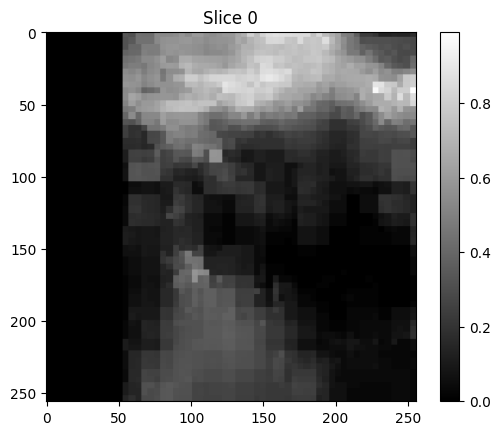

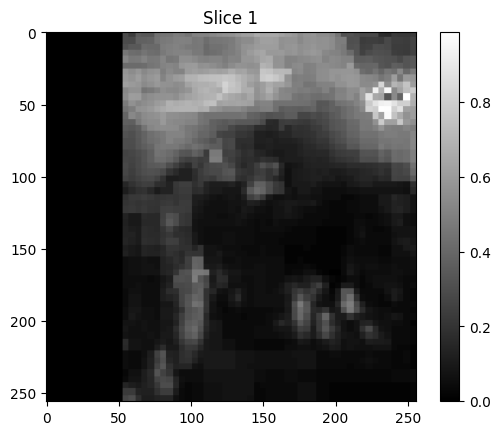

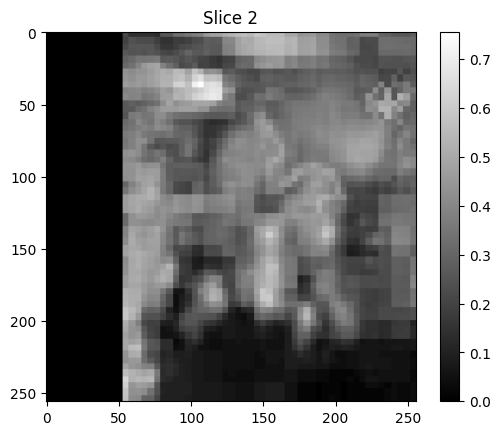

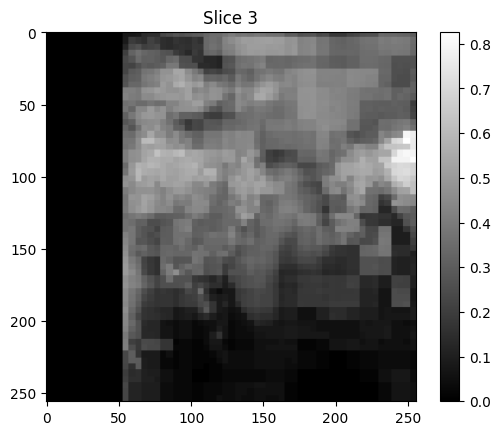

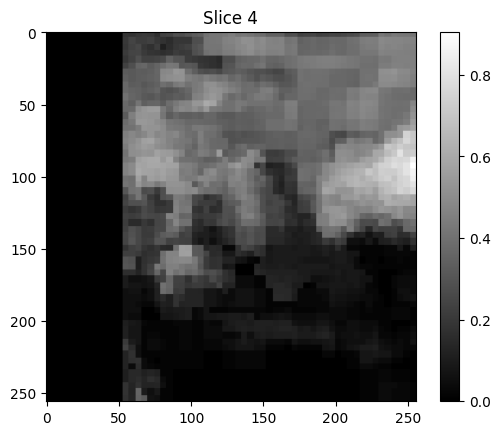

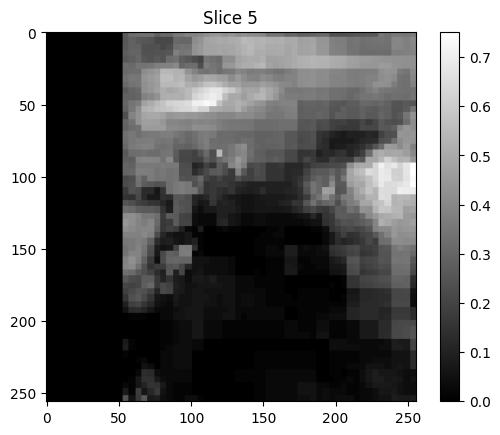

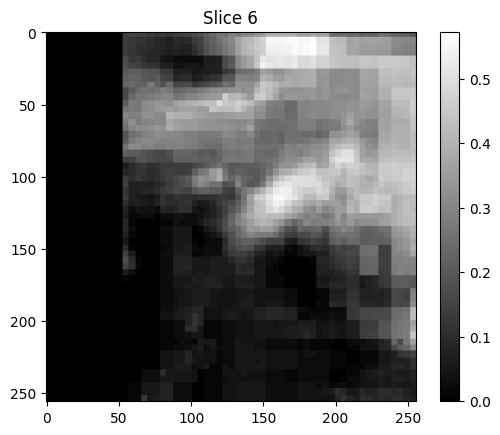

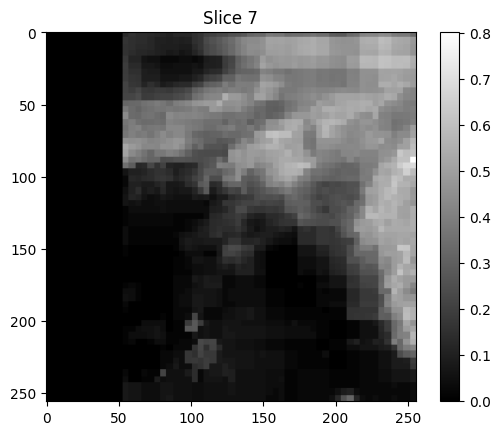

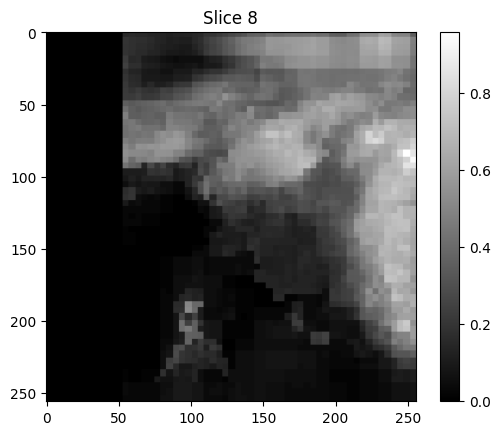

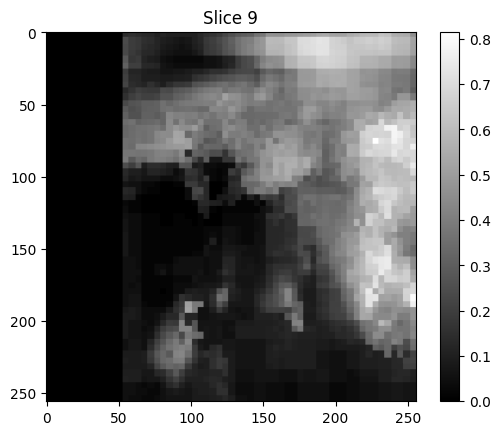

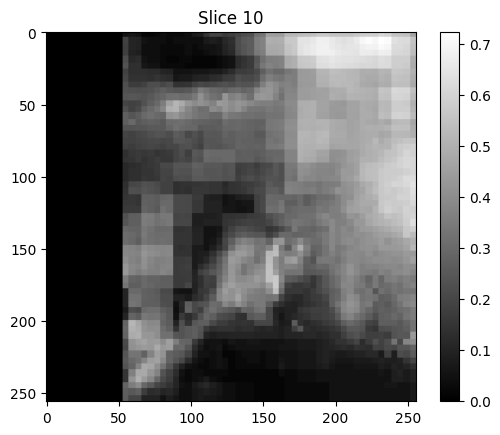

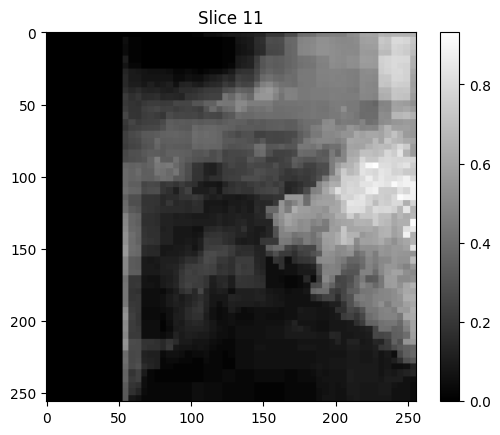

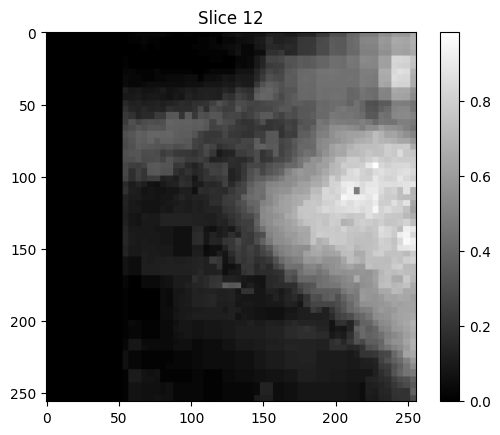

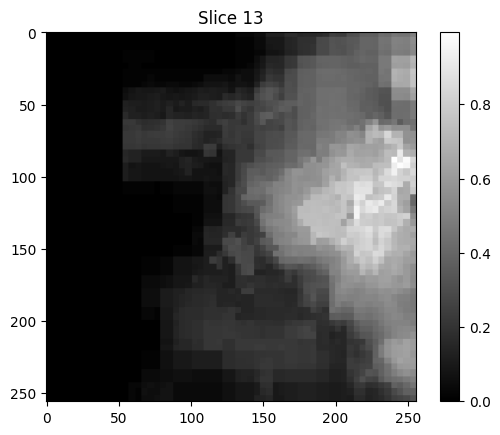

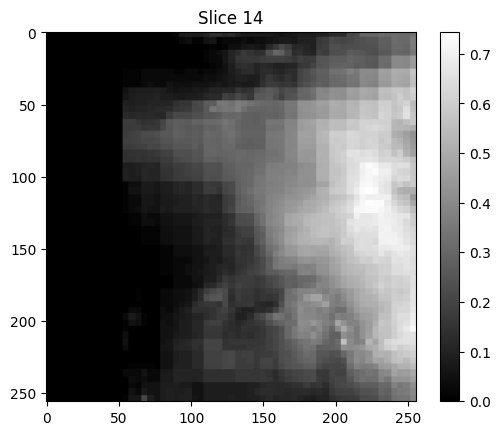

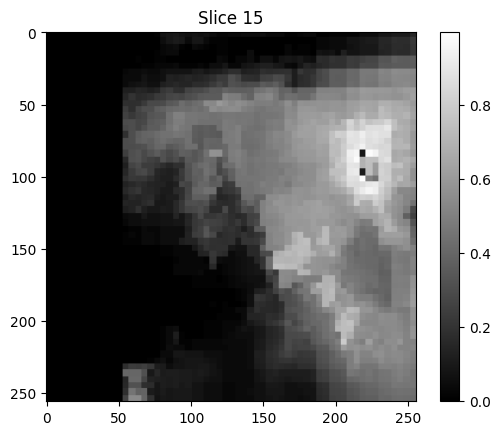

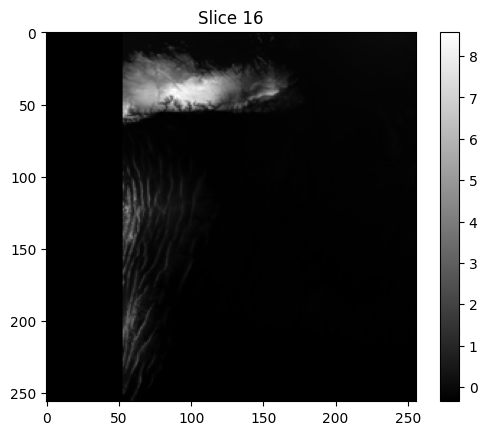

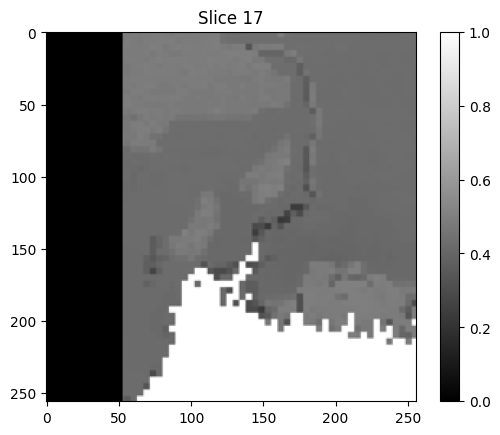

In [39]:
import matplotlib.pyplot as plt

# Assume 'a' is a 3D tensor with shape [n, height, width]
a = training_dataset.__getitem__(0)[0]
n = a.shape[0]  # Number of 2D slices

for i in range(n):
    plt.imshow(a[i].numpy(), cmap='gray')  # Convert to numpy array and use grayscale
    plt.title(f'Slice {i}')
    plt.colorbar()  # Optionally add a color bar
    plt.show()

/tmp/ipykernel_658381/1315105601.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  roi = (image >= val_l)
/tmp/ipykernel_658381/1315105601.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  image2 = (image - mu) / (sigma + eps)
/tmp/ipykernel_658381/1315105601.py:49: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rain_image /= 1000.0
/tmp/ipykernel_658381/1315105601.py:50: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rain_image = np.log(rain_image + 1)
/tmp/ipykernel_658381/1315105601.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2

0.0 4.1972017
0.0 0.99133533
0.0 4.1972017
0.0 0.9882954
0.0 4.1972017
0.0 0.7565577
0.0 4.1972017
0.0 0.82711357
0.0 4.1972017
0.0 0.90562516
0.0 4.1972017
0.0 0.7515283
0.0 4.1972017
0.0 0.5726472
0.0 4.1972017
0.0 0.80278045
0.0 4.1972017
0.0 0.9582548
0.0 4.1972017
0.0 0.81574327
0.0 4.1972017
0.0 0.7246537
0.0 4.1972017
0.0 0.93324333
0.0 4.1972017
0.0 0.9856959
0.0 4.1972017
0.0 0.9954789
0.0 4.1972017
0.0 0.7444401
0.0 4.1972017
0.0 0.9982019


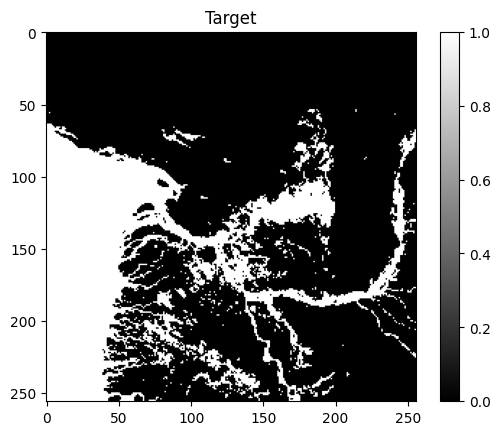

In [40]:
b = training_dataset.__getitem__(0)[1]
n = a.shape[0]  # Number of 2D slices

plt.imshow(b.numpy(), cmap='gray')  # Convert to numpy array and use grayscale
plt.title(f'Target')
plt.colorbar()  # Optionally add a color bar
plt.show()